# Estimate a0 with a GP using periodic kernels and sparse approx.

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

#from soda.dataio.conversion import readotps

from scipy.optimize import fmin_powell, fmin, fmin_cg, fmin_ncg

from theano import shared

from theano import tensor as tt
import arviz as az

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from mycurrents import oceanmooring as om
from soda.utils.harmonic_analysis import harmonic_fit_array
from soda.utils.mysignal import power_spectra

from scipy import signal

from tqdm import tqdm

import matplotlib as mpl

/home/suntans/code/soda/soda/dataio/netcdfio.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ncmeta = yaml.load(f)


In [2]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 'large'

In [3]:
####
# Inputs

# basedir = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/'
basedir = '/home/suntans/cloudstor/Data/Crux/'
ncfile = '{}/KP150_Fitted_Buoyancy_wout_motion.nc'.format(basedir)

subsample = 60

basetime = datetime(2016,1,1)
# outtime = pd.date_range('2016-05-01','2017-05-02',freq='1H').values
outtime = pd.date_range('2017-04-01','2017-04-15',freq='1H').values

tout = np.array(SecondsSince(outtime, basetime=basetime))
tout /= 86400
tout[0:2]

array([456.        , 456.04166667])

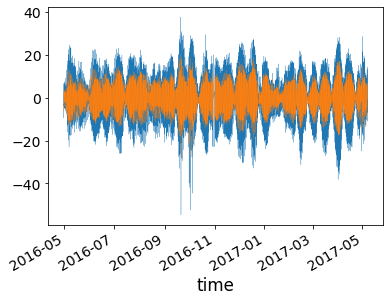

In [4]:
# Load the time-series data
ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Filter each time series and concatenate
A1 = om.OceanMooring(ds1.time.values, ds1['A_n'][:,0],0.0)
A2 = om.OceanMooring(ds2.time.values, ds2['A_n'][:,0],0.0)

A1f = om.OceanMooring(A1.t, A1.filt((34*3600, 6*3600), btype='band'), 0.0)
A2f = om.OceanMooring(A2.t, A2.filt((34*3600, 6*3600), btype='band'), 0.0)

A_n = A1f.concat(A2f)
A_n_1h_6 = xr.DataArray(A_n.y[::subsample], dims=('time'), coords={'time':A_n.t[::subsample]})

A1f = om.OceanMooring(A1.t, A1.filt((34*3600, 3*3600), btype='band'), 0.0)
A2f = om.OceanMooring(A2.t, A2.filt((34*3600, 3*3600), btype='band'), 0.0)


A_n = A1f.concat(A2f)
A_n_1h = xr.DataArray(A_n.y[::subsample], dims=('time'), coords={'time':A_n.t[::subsample]})

plt.figure()
A_n_1h.plot(lw=0.25)
A_n_1h_6.plot(lw=0.2)


((8917,),
 [0.517525050851839,
  0.5,
  0.527431176868261,
  0.9972695689985752,
  1.0758059026974014,
  0.2587625254259195,
  0.17250835028394632])

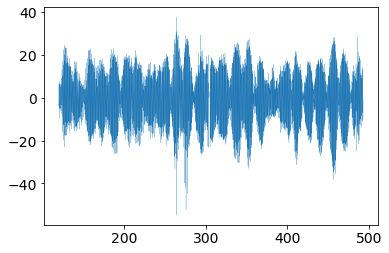

In [5]:
# Prepare the inputs

# X_sd = A_n_1h.y.std()
# X_mu = A_n_1h.y.mean()

y_sd = 1
y_mu = 0

idx = ~np.isnan(A_n_1h.values)
yd = A_n_1h.values[idx] - y_mu
yd /= y_sd

timein = A_n_1h.time.values[idx]
dtime = SecondsSince(timein, basetime=basetime )
xd= dtime/86400.

tidecons = ['M2','S2','N2','K1','O1','M4','M6'] # Tidal harmonic
# tidecons = ['M2','S2','N2','K1','O1'] # Tidal harmonic

frq,names = getTideFreq(tidecons)

T = [2*np.pi/ff/86400 for ff in frq]


plt.figure()
plt.plot(xd,yd,lw=0.2)
xd.shape, T

In [10]:
# tidecons = ['M2','S2','N2','K1','O1']
#tidecons = ['M2','S2','N2','K1','O1','M4']
#tidecons = ['M2','M4','O1']
tidecons = ['M2','S2']


frq,names = getTideFreq(tidecons)
T = [2*np.pi/ff/86400 for ff in frq]
print(len(T))
with pm.Model() as marginal_gp_model:
    # Priors
    #T = pm.Normal("T", 4.5,0.2)
    tday = 1/86400.
    nf = len(T) #+ 1
    
    # Kernel hyperparameters
    #ℓ = pm.Normal("ℓ", 1,1, shape=nf)
    ℓ = pm.Normal("ℓ", 20,5, shape=nf)
    η = pm.Normal("η", 5,2, shape=nf)

    # Noise
    σ = pm.InverseGamma("σ", alpha=3,beta=0.5)    


    # Specify the covariance function.
    K = η[0] ** 2 * pm.gp.cov.Cosine(1, T[0]) * pm.gp.cov.Exponential(1, ℓ[0])
    for ii in range(1,nf):
        K += η[ii] ** 2 * pm.gp.cov.Cosine(1, T[ii]) * pm.gp.cov.Exponential(1, ℓ[ii])
    
    # Add a squared exponential term to clean up the residual
    #K += η[nf-1] ** 2 * pm.gp.cov.Matern32(1,ℓ[nf-1])
    
    # Full-rank method
    #gp = pm.gp.Marginal(cov_func=K)
    #y_ = gp.marginal_likelihood("y", X=xd[:,None]*scale, y=yd, noise=σ)
    
    # Sparse approx
    Xu = pm.gp.util.kmeans_inducing_points(100, xd[:,None])
    gp = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    y_ = gp.marginal_likelihood("y", X=xd[:,None], Xu=Xu, y=yd, noise=σ)
    
    # Compute the marginal posterior
    #mp = pm.find_MAP()
    
    trace=pm.sample()
    
    # This is for making predictions later...
    #fnew = gp.conditional("fnew", Xnew=tout[:,None])


2


<ipython-input-10-3a5d23d792f3>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]


ValueError: Not enough samples to build a trace.

In [7]:
mp

{'ℓ': array([26.03475957, 30.89544547]),
 'η': array([8.68837363, 3.26051196]),
 'σ_log__': array(1.06107544),
 'σ': array(2.88947678)}

In [8]:
# Make predictions
with marginal_gp_model:
    fnew = gp.conditional("fnew", Xnew=tout[:,None])
    ppc = pm.sample_posterior_predictive([mp], samples=100, var_names=['fnew'])


(-40.0, 40.0)

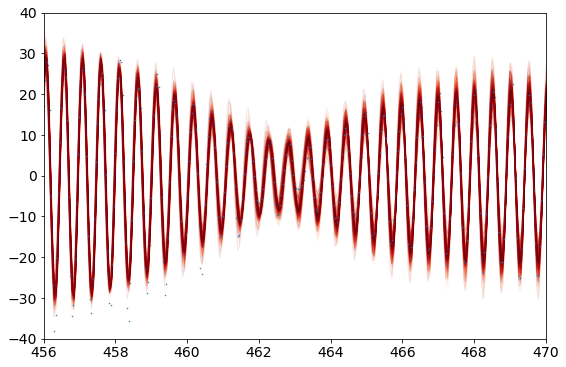

In [9]:
plt.figure(figsize=(9,6))
ax=plt.gca()
pm.gp.util.plot_gp_dist(ax, ppc['fnew'], tout)
plt.plot(xd,yd,'.',markersize=1.)
plt.xlim(tout[0],tout[-1])
plt.ylim(-40,40)